# Testing

#### Still partially relying on pandas, need to remove it completely once everything works

In [1]:
# Import modules
from sqlalchemy import create_engine, MetaData, Table, update
from sqlalchemy import Column, Integer, String, DateTime, ForeignKey
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.engine.url import URL

import arxiv
import pandas as pd

In [2]:
# Used full file path for testing purpose
json_file = pd.read_json("/Users/EmilyWang/Downloads/ops-master/paper-collector/DeepLearningArticles.json", orient='index')

In [4]:
# Extracting information
json_file['published_date'] = json_file['published'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
json_file['published_time'] = json_file['published'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
json_file['updated_date'] = json_file['updated'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
json_file['updated_time'] = json_file['updated'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
json_file['unique_id'] = json_file['id'].str.extract('(\d\d\d\d\.\d\d\d\d\d)', expand=True)
json_file['version_number'] = json_file['id'].str.extract('(\d$)', expand=True)

final_json = json_file[['unique_id', 'version_number', 'author', 
                        'title', 'summary', 'arxiv_comment', 
                        'published_date', 'published_time', 
                        'updated_date', 'updated_time', 
                        'tags', 'authors']]

final_json = final_json.drop_duplicates(subset='unique_id', keep='first', inplace=False).dropna(
                        subset=['unique_id'], inplace=False)

In [5]:
def obtain_new_articles():
    new_articles = arxiv.query(search_query, max_results=5000,
                               sort_by="lastUpdatedDate", sort_order="descending")
    new_articles_df = pd.DataFrame.from_dict(new_articles)
    ordered_new_articles = new_articles_df.reindex(
                            columns=['title', 'author', 'authors', 'id', 'arxiv_comment',
                                     'arxiv_primary_category', 'published', 'summary',
                                     'tags', 'updated'])
    return ordered_new_articles

def extract_column(df_file):
    # Extracting information
    df_file['published_date'] = df_file['published'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
    df_file['published_time'] = df_file['published'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
    df_file['updated_date'] = df_file['updated'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
    df_file['updated_time'] = df_file['updated'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
    df_file['unique_id'] = df_file['id'].str.extract('(\d\d\d\d\.\d\d\d\d\d)', expand=True)
    df_file['version_number'] = df_file['id'].str.extract('(\d$)', expand=True)

    final_df = df_file[['unique_id', 'version_number', 'author', 
                        'title', 'summary', 'arxiv_comment', 
                        'published_date', 'published_time', 
                        'updated_date', 'updated_time', 
                        'tags', 'authors']]

    final_df = final_df.drop_duplicates(subset='unique_id', keep='first', inplace=False)
    return final_df

def check_existence(session, PaperTable, id_string):
    query = session.query(PaperTable).filter(PaperTable.id==id_string)
    
    if query.one_or_none():
        return True
    else:
        return False

def update_existing_articles(session, PaperTable, id_string, df):
    now = datetime.now
    update(PaperTable).where(PaperTable.id==id_string).\
            values(version = int(df.iloc[0, 1]), \
                   summary = df.iloc[0, 4], \
                   arxiv_comment = df.iloc[0, 5], \
                   updated_date = df.iloc[0, 8], \
                   updated_time = df.iloc[0, 9])

    session.commit()

def extract_category(df):
    tags = df.iloc[0, 10]
    tags_list = []
    for i in range(len(tags)):
        tags_list.append([tags[i]['term']])
    return tags_list

def insert_new_articles(session, PaperTable, AuthorTable, TagTable, id_string, df):
    # Adding records into Paper Table
    paper_row = PaperTable(id = id_string, 
                           version = int(df.iloc[0, 1]), 
                           author = df.iloc[0, 2], 
                           title = df.iloc[0, 3], 
                           summary = df.iloc[0, 4], 
                           arxiv_comment = df.iloc[0, 5], 
                           published_date = df.iloc[0, 6], 
                           published_time = df.iloc[0, 7], 
                           updated_date = df.iloc[0, 8], 
                           updated_time = df.iloc[0, 9])
    session.add(paper_row)
    session.commit()
    
    # Adding records into Author Table
    authors = df.iloc[0, 11]
    for i in range(len(authors)):
        id_str = id_string + "-" + str(i)
        author_row = AuthorTable(id = id_str, 
                                 author = authors[i], 
                                 author_entry = paper_row)
        session.add(author_row)
    session.commit()
    
    # Adding records into Tag Table
    tags_list = extract_category(df)
    for i in range(len(tags_list)):
        id_str = id_string + "-" + str(i)
        tag_row = TagTable(id = id_str, 
                           paper_tag = tags_list[i], 
                           tag_entry = paper_row)
        session.add(tag_row)
    session.commit()

In [6]:
# Local db url
db_url = {'drivername': 'postgres',
          'username': 'postgres',
          'password': 'postgres',
          'host': '127.0.0.1',
          'port': 5432}
engine = create_engine(URL(**db_url))

# Initiate base
Base = declarative_base()

# Create tables
class PaperTable(Base):
    __tablename__ = 'PaperTable'
    id = Column(String, primary_key=True)
    version = Column(Integer, nullable=False)
    author = Column(String, nullable=False)
    authors = relationship('AuthorTable', 
                           backref='author_entry')
    tags = relationship('TagTable', 
                        backref='tag_entry')
    title = Column(String, nullable=False)
    summary = Column(String)
    arxiv_comment = Column(String)
    published_date = Column(String)
    published_time = Column(String)
    updated_date = Column(String)
    updated_time = Column(String)

class AuthorTable(Base):
    __tablename__ = 'AuthorTable'
    id = Column(String, primary_key=True)
    author = Column(String, nullable=False)
    paper_id = Column(String, ForeignKey('PaperTable.id'))

class TagTable(Base):
    __tablename__ = 'TagTable'
    id = Column(String, primary_key=True)
    paper_tag = Column(String, nullable=False)
    paper_id = Column(String, ForeignKey('PaperTable.id'))

Base.metadata.create_all(bind=engine)

Session = sessionmaker(bind=engine)
session = Session()

In [7]:
final_json_lst = final_json['unique_id'].values

for id_string in final_json_lst:
    row_df = final_json[final_json['unique_id']==id_string]

    if check_existence(session, PaperTable, id_string):
        exist_version = session.query(PaperTable.version).filter(PaperTable.id==id_string)
        if int(final_json[final_json['unique_id']==id_string]['version_number']) \
                > exist_version[0]:
            update_existing_articles(session, PaperTable, id_string, row_df)

    else:
        insert_new_articles(session, PaperTable, AuthorTable, TagTable, id_string, row_df)

In [8]:
from sqlalchemy import and_
# Testing if foreign keys/relationships work
query = session.query(PaperTable, AuthorTable, TagTable).filter(and_(PaperTable.id==AuthorTable.paper_id, 
                                                                PaperTable.id==TagTable.paper_id)).limit(20)
for _p, _a, _t in query.all():
    print(_p.id, _a.author, _t.paper_tag)

1903.04488 Nikita Ivkin {stat.ML}
1903.04488 Nikita Ivkin {math.OC}
1903.04488 Nikita Ivkin {cs.DC}
1903.04488 Nikita Ivkin {cs.AI}
1903.04488 Nikita Ivkin {cs.LG}
1903.04488 Daniel Rothchild {stat.ML}
1903.04488 Daniel Rothchild {math.OC}
1903.04488 Daniel Rothchild {cs.DC}
1903.04488 Daniel Rothchild {cs.AI}
1903.04488 Daniel Rothchild {cs.LG}
1903.04488 Enayat Ullah {stat.ML}
1903.04488 Enayat Ullah {math.OC}
1903.04488 Enayat Ullah {cs.DC}
1903.04488 Enayat Ullah {cs.AI}
1903.04488 Enayat Ullah {cs.LG}
1903.04488 Vladimir Braverman {stat.ML}
1903.04488 Vladimir Braverman {math.OC}
1903.04488 Vladimir Braverman {cs.DC}
1903.04488 Vladimir Braverman {cs.AI}
1903.04488 Vladimir Braverman {cs.LG}


In [9]:
from sqlalchemy import func
rows = session.query(func.count(PaperTable.id)).scalar()
auth = session.query(func.count(AuthorTable.id)).scalar()
tags = session.query(func.count(TagTable.id)).scalar()
print(rows, auth, tags)

10051 41396 22696


# Complete Code

In [10]:
### Complete
# Import modules
from sqlalchemy import create_engine, MetaData, Table, update
from sqlalchemy import Column, Integer, String, ForeignKey
from sqlalchemy import inspect
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.engine.url import URL

import arxiv
import pandas as pd

# Keywords include deep learning, neural network, GPU, graphics processing unit,
# reinforcement learning, OR perceptron
keyword = '%28%22deep learning%22 OR %22neural network%22 \
            OR %22GPU%22 OR %22graphics processing unit%22 \
            OR %22reinforcement learning%22 OR %22perceptron%22%29'

# Searches within machine learning (stats or cs), artificial intelligence or computer vision
category = '%28cat:cs.LG OR cat:stat.ML OR cat:cs.AI OR cat:cs.CV%29'

search_query = keyword + " AND " + category

# Use create_tables when first setting up the database
def create_tables():
    # Initiate base
    Base = declarative_base()
    
    # Create tables
    class PaperTable(Base):
        __tablename__ = 'PaperTable'
        id = Column(String, primary_key=True)
        version = Column(Integer, nullable=False)
        author = Column(String, nullable=False)
        authors = relationship('AuthorTable', 
                               backref='author_entry')
        tags = relationship('TagTable', 
                            backref='tag_entry')
        title = Column(String, nullable=False)
        summary = Column(String)
        arxiv_comment = Column(String)
        published_date = Column(String)
        published_time = Column(String)
        updated_date = Column(String)
        updated_time = Column(String)
        
    class AuthorTable(Base):
        __tablename__ = 'AuthorTable'
        id = Column(String, primary_key=True)
        author = Column(String, nullable=False)
        paper_id = Column(String, ForeignKey('PaperTable.id'))
        
    class TagTable(Base):
        __tablename__ = 'TagTable'
        id = Column(String, primary_key=True)
        paper_tag = Column(String, nullable=False)
        paper_id = Column(String, ForeignKey('PaperTable.id'))
        
    Base.metadata.create_all(bind=engine)

# max_results set to 1000
def obtain_new_articles():
    new_articles = arxiv.query(search_query, max_results=5000,
                               sort_by="lastUpdatedDate", 
                               sort_order="descending")
    new_articles_df = pd.DataFrame.from_dict(new_articles)
    ordered_new_articles = new_articles_df.reindex(
                            columns=['title', 'author', 'authors', 'id', 'arxiv_comment',
                                     'arxiv_primary_category', 'published', 'summary',
                                     'tags', 'updated'])
    return ordered_new_articles

def extract_column(df_file):
    # Extracting information
    df_file['published_date'] = df_file['published'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
    df_file['published_time'] = df_file['published'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
    df_file['updated_date'] = df_file['updated'].str.extract('(\d\d\d\d-\d\d-\d\d)', expand=True)
    df_file['updated_time'] = df_file['updated'].str.extract('(\d\d:\d\d:\d\d)', expand=True)
    df_file['unique_id'] = df_file['id'].str.extract('(\d\d\d\d\.\d\d\d\d\d)', expand=True)
    df_file['version_number'] = df_file['id'].str.extract('(\d$)', expand=True)

    final_df = df_file[['unique_id', 'version_number', 'author', 
                        'title', 'summary', 'arxiv_comment', 
                        'published_date', 'published_time', 
                        'updated_date', 'updated_time', 
                        'tags', 'authors']]

    final_df = final_df.drop_duplicates(subset='unique_id', 
                                        keep='first', inplace=False)
    final_df = final_df.dropna(subset=['unique_id'], inplace=False)
    return final_df

def check_existence(session, PaperTable, id_string):
    query = session.query(PaperTable).filter(PaperTable.c.id==id_string).all()
    
    if len(query) > 0:
        return True
    else:
        return False

def update_existing_articles(session, PaperTable, id_string, df):
    upd = update(PaperTable).where(PaperTable.c.id==id_string).\
                             values(version = int(df.iloc[0, 1]), \
                                    summary = df.iloc[0, 4], \
                                    arxiv_comment = df.iloc[0, 5], \
                                    updated_date = df.iloc[0, 8], \
                                    updated_time = df.iloc[0, 9])

    session.execute(upd)
    session.commit()

def extract_category(df):
    tags = df.iloc[0, 10]
    tags_list = []
    for i in range(len(tags)):
        tags_list.append([tags[i]['term']])
    return tags_list

def insert_new_articles(session, PaperTable, AuthorTable, TagTable, 
                        id_string, df):
    # Adding records into Paper Table
    paper_row = PaperTable.insert().values(id = id_string, 
                                           version = int(df.iloc[0, 1]), 
                                           author = df.iloc[0, 2], 
                                           title = df.iloc[0, 3], 
                                           summary = df.iloc[0, 4], 
                                           arxiv_comment = df.iloc[0, 5], 
                                           published_date = df.iloc[0, 6], 
                                           published_time = df.iloc[0, 7], 
                                           updated_date = df.iloc[0, 8], 
                                           updated_time = df.iloc[0, 9])
    
    session.execute(paper_row)
    session.commit()
    
    # Adding records into Author Table
    authors = df.iloc[0, 11]
    for i in range(len(authors)):
        id_str = id_string + "-" + str(i)
        author_row = AuthorTable.insert().values(id = id_str, 
                                                 author = authors[i], 
                                                 paper_id = id_string)
    
        session.execute(author_row)
        session.commit()
    
    # Adding records into Tag Table
    tags_list = extract_category(df)
    for i in range(len(tags_list)):
        id_str = id_string + "-" + str(i)
        tag_row = TagTable.insert().values(id = id_str, 
                                           paper_tag = tags_list[i], 
                                           paper_id = id_string)
    
        session.execute(tag_row)
        session.commit()

def main():
    # Local db url
    db_url = {'drivername': 'postgres',
              'username': 'postgres',
              'password': 'postgres',
              'host': '127.0.0.1',
              'port': 5432}
    engine = create_engine(URL(**db_url))
    connection = engine.connect()
    print("Existing tables:", engine.table_names())

    # reflect the tables
    metadata = MetaData()
    Base = automap_base(metadata=metadata)
    Base.prepare(engine, reflect=True)

    # Mapped classes with names matching that of the table name
    PaperTable = Table('PaperTable', metadata, autoload=True, 
                       autoload_with=engine)
    AuthorTable = Table('AuthorTable', metadata, autoload=True, 
                        autoload_with=engine)
    TagTable = Table('TagTable', metadata, autoload=True, 
                     autoload_with=engine)
    
    # Inspect table columns
    #inspect_paper = inspect(PaperTable)
    #col_list_p = [column.name for column in inspect_paper.c]
    #print(col_list_p)
    
    #inspect_author = inspect(AuthorTable)
    #col_list_a = [column.name for column in inspect_author.c]
    #print(col_list_a)
    
    Session = sessionmaker(bind=engine)
    session = Session()
    
    article_df = extract_column(obtain_new_articles())
    #article_df = extract_column(pd.read_json("/Users/EmilyWang/Desktop/ops/paper-collector/DeepLearningArticles.json", 
    #                                         orient='index'))
    article_id_lst = article_df['unique_id'].values
    
    count_update = 0
    count_insert = 0

    for id_string in article_id_lst:
        row_df = article_df[article_df['unique_id']==id_string]
        
        if check_existence(session, PaperTable, id_string):
            exist_version = session.query(PaperTable.c.version).\
                                    filter(PaperTable.c.id==id_string).one()
            if int(article_df.iloc[0, 1]) > exist_version[0]:
                update_existing_articles(session, 
                                         PaperTable, id_string, row_df)
                count_update = count_update + 1
                
        else:
            insert_new_articles(session, PaperTable, AuthorTable, 
                                TagTable, id_string, row_df)
            count_insert = count_insert + 1
    
    print("Inserted {} new articles, updated {} existing articles.".format(count_insert, count_update))
    session.close()


main()


Existing tables: ['PaperTable', 'TagTable', 'AuthorTable']
Inserted 299 new articles, updated 2823 existing articles.


In [11]:
# Local db url
db_url = {'drivername': 'postgres',
          'username': 'postgres',
          'password': 'postgres',
          'host': '127.0.0.1',
          'port': 5432}
engine = create_engine(URL(**db_url))
connection = engine.connect()
print("Existing tables:", engine.table_names())

# reflect the tables
metadata = MetaData()
Base = automap_base(metadata=metadata)
Base.prepare(engine, reflect=True)

# Mapped classes with names matching that of the table name
PaperTable = Table('PaperTable', metadata, autoload=True, 
                   autoload_with=engine)
AuthorTable = Table('AuthorTable', metadata, autoload=True, 
                    autoload_with=engine)
TagTable = Table('TagTable', metadata, autoload=True, 
                 autoload_with=engine)

inspect_paper = inspect(PaperTable)
col_list_p = [column.name for column in inspect_paper.c]
print(col_list_p)

inspect_author = inspect(AuthorTable)
col_list_a = [column.name for column in inspect_author.c]
print(col_list_a)

Session = sessionmaker(bind=engine)
session = Session()

from sqlalchemy import func
rows = session.query(func.count(PaperTable.c.id)).scalar()
auth = session.query(func.count(AuthorTable.c.id)).scalar()
tags = session.query(func.count(TagTable.c.id)).scalar()
print(rows, auth, tags)

Existing tables: ['PaperTable', 'TagTable', 'AuthorTable']
['id', 'version', 'author', 'title', 'summary', 'arxiv_comment', 'published_date', 'published_time', 'updated_date', 'updated_time']
['id', 'author', 'paper_id']
10350 42672 23339


In [13]:
from sqlalchemy import and_
# Testing if foreign keys/relationships work
query = session.query(
                PaperTable.c.id, AuthorTable.c.paper_id, AuthorTable.c.author).filter(
                PaperTable.c.id==AuthorTable.c.paper_id).limit(10)

for row in query:
    print(row)

('1903.04488', '1903.04488', 'Nikita Ivkin')
('1903.04488', '1903.04488', 'Daniel Rothchild')
('1903.04488', '1903.04488', 'Enayat Ullah')
('1903.04488', '1903.04488', 'Vladimir Braverman')
('1903.04488', '1903.04488', 'Ion Stoica')
('1903.04488', '1903.04488', 'Raman Arora')
('1803.08607', '1803.08607', 'Tao Sheng')
('1803.08607', '1803.08607', 'Chen Feng')
('1803.08607', '1803.08607', 'Shaojie Zhuo')
('1803.08607', '1803.08607', 'Xiaopeng Zhang')


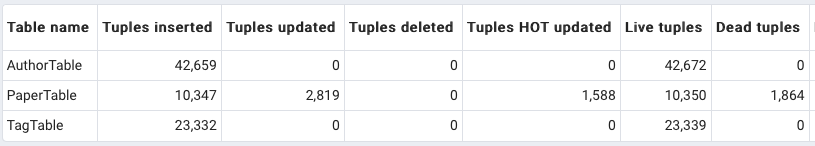